In [1]:
import pandas as pd
from scipy.optimize import minimize
import numpy as np
from Syn_data_gen import *
from matplotlib import pyplot as plt
import multiprocessing as mp

## Create the similarity matrix

In [2]:
def create_sim(user_unknown, base_rates, lower_threshold=0.0):
    '''

    Create the similarity vector between user_unknown and each user in base_rates using cosine similarity. The items not rated by any of the two users are ignored.
    (Consider improve this function using numpy built-in functions)

    :param user_unknown:
    :param base_rates:
    :return:
    '''
    user_sim = np.array([])

    for user in range(len(base_rates)):
        sumx = 0
        sumy = 0
        sumxy = 0

        for idx in range(len(base_rates.columns)):
            if not np.isnan(user_unknown.iloc[idx]) and not np.isnan(base_rates.iloc[user, idx]):
                sumx += user_unknown.iloc[idx] * user_unknown.iloc[idx]
                sumy += base_rates.iloc[user, idx] * base_rates.iloc[user, idx]
                sumxy += user_unknown.iloc[idx] * base_rates.iloc[user, idx]

        new_sim = sumxy/(np.sqrt(sumx)*np.sqrt(sumy))
        if 0 <= new_sim < lower_threshold:
            user_sim = np.append(user_sim, lower_threshold)
        elif 0 > new_sim > -lower_threshold:
            user_sim = np.append(user_sim, -lower_threshold)
        else:
            user_sim = np.append(user_sim, new_sim)

    return user_sim

## Declare the pipelines for each algo

In [16]:
def pipeline_mean(base_rates: pd.DataFrame, user_sim: np.array, user: int, item: int, reg=0.0, lower_threshold=0.0):
    #user_unknown = base_rates.iloc[user]
    base_rates = base_rates.drop(user)
    #user_sim = create_sim(user_unknown, base_rates)
    sum_sim = 0
    rate = 0
    for user_row in range(len(base_rates)):
        if not np.isnan(base_rates.iloc[user_row, -1]):
            sum_sim += np.abs(user_sim[user_row])
            rate += user_sim[user_row] * base_rates.iloc[user_row, item]
    if sum_sim == 0:
        return 0
    else:
        return rate/sum_sim

In [4]:
def pipeline_median(base_rates: pd.DataFrame, user_sim: np.array, user: int, item: int, reg=0.0, lower_threshold=0.0):
    #user_unknown = base_rates.iloc[user]
    base_rates = base_rates.drop(user)
    #user_sim = create_sim(user_unknown, base_rates, lower_threshold)

    # Zip weights and rates
    weights_rates = np.stack([user_sim, base_rates.iloc[:,item]], axis=1)

    # Inverse rates and weights for negative weights
    weights_rates = np.apply_along_axis(lambda arr: arr if arr[0] >= 0 else -arr, 1, weights_rates)

    # Sort by rates
    sorted_list = weights_rates[np.argsort(weights_rates[:,1])]

    # Remove nans
    clean_array = sorted_list[~np.isnan(sorted_list).any(axis=1)]

    # Sum the weights of the remaining entries
    sum_weights = np.sum(clean_array[:,0])

    # Accumulate the weights and stopping when reaching the half of the sum
    weights_acc = 0
    for w_user in clean_array:

        weights_acc += w_user[0]
        if weights_acc > sum_weights/2:
            return w_user[1]


    return 0

In [5]:
def pipeline_qrw_med(rates: pd.DataFrame, user_sim: np.array, user: int, item: int, reg=0.0, lower_threshold=0.0):
    #user_unknown = rates.iloc[user]
    base_rates = rates.drop(user)
    #user_sim = create_sim(user_unknown, base_rates)

    # Zip weights and rates
    weights_rates = np.stack([user_sim, base_rates.iloc[:,item]], axis=1)

    # Inverse rates and weights for negative weights
    weights_rates = np.apply_along_axis(lambda arr: arr if arr[0] >= 0 else -arr, 1, weights_rates)

    def qrw_med(x, weights_rates, reg):
        acc = 0.0
        for weight_rate in weights_rates:
            if not np.isnan(weight_rate[1]):
                acc += weight_rate[0]*np.abs(weight_rate[1]-x)

        return acc + (reg * x**2)

    return minimize(qrw_med, np.array([0]), (weights_rates, reg)).x[0]

## Compute the prediction for some values of the attacker

In [6]:
def compute_att_pred_for_range(ratings, range=20, reg=0.0, nb_attackers=1, algo='qrmed', lower_threshold=0.0):
    mal_vals_to_test = np.arange(-range, range, int(range/5))

    prediction = np.array([])

    thresh = 0

    if algo == 'qrmed':
        func = pipeline_qrw_med
    elif algo == 'mean':
        func = pipeline_mean
    elif algo == 'median':
        func = pipeline_median
        thresh = lower_threshold
    else:
        raise ValueError('Unknown algo {}'.format(algo))


    for mal_val in mal_vals_to_test:
        att_ratings = inject_attackers(ratings, nb_attackers, mal_val)

        user_sim = create_sim(att_ratings.iloc[0], att_ratings.drop(0), thresh)

        prediction = np.append(prediction, func(att_ratings, user_sim, 0, -1, reg, lower_threshold))

    return prediction

## Generate the synthetic data

In [7]:
ratings_df, long_df, meta = generate_synthetic_ratings(
    n_users=100,
    n_items=50,
    n_factors=6,
    n_groups=5,
    group_strength=0.1,
    user_noise=0.1,
    item_scale=0.1,
    user_bias_std=0.0,
    item_bias_std=0.0,
    global_mean=0.0,
    noise_std=0.05,
    rating_min=None,
    rating_max=None,
    random_seed=0
)

ratings_df = inject_nans(ratings_df, 0.6, 0)

print("Generated matrix shape:", ratings_df.shape)

ratings_df

Generated matrix shape: (100, 50)


,0,1,2,3,4,5,6,7,8,9,...,40,41,42,43,44,45,46,47,48,49
0,-0.394674,NaN,NaN,NaN,-0.227542,0.033453,-0.211666,-0.041365,NaN,-0.410358,...,NaN,NaN,NaN,NaN,NaN,-0.091771,NaN,-0.152258,NaN,-0.369670
1,-0.281981,NaN,-0.517305,NaN,NaN,NaN,NaN,0.400930,NaN,NaN,...,0.156050,-0.143617,NaN,0.388701,0.135379,-0.325975,NaN,-0.126219,0.015961,-0.086175
2,NaN,NaN,-0.542684,0.365954,NaN,NaN,NaN,0.305038,NaN,-0.326129,...,NaN,NaN,-0.047419,NaN,NaN,-0.284699,NaN,-0.135756,NaN,-0.152931
3,NaN,NaN,NaN,-0.005354,NaN,-0.017659,0.005187,NaN,0.014036,NaN,...,NaN,NaN,NaN,NaN,-0.265783,NaN,NaN,0.046497,-0.182657,NaN
4,NaN,NaN,-0.631196,NaN,NaN,0.615980,0.230264,NaN,NaN,-0.301161,...,NaN,-0.347528,-0.075689,NaN,0.084483,-0.225688,-0.067207,-0.125369,NaN,-0.049960
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,-0.217740,NaN,NaN,0.300119,-0.773184,0.530891,NaN,0.316591,-0.241072,NaN,...,NaN,-0.284445,-0.010974,NaN,NaN,NaN,NaN,-0.169910,NaN,-0.081071
96,-0.386010,NaN,0.248895,NaN,-0.131339,-0.031423,NaN,NaN,NaN,NaN,...,-0.148696,NaN,NaN,NaN,NaN,0.004973,-0.062604,NaN,0.322216,NaN
97,-0.127307,0.455464,NaN,0.311222,-0.712594,NaN,0.163919,0.373270,NaN,NaN,...,NaN,NaN,-0.081977,NaN,NaN,NaN,-0.223310,NaN,-0.051357,-0.156935
98,NaN,-0.006601,0.173605,NaN,0.217927,NaN,NaN,NaN,0.054877,0.145589,...,NaN,NaN,0.036908,NaN,NaN,NaN,NaN,NaN,NaN,0.048370


In [8]:
real_grade = ratings_df.iloc[0, -1]
ratings_att = inject_attackers(ratings_df, nb_attackers=10, att_grade=100000)

In [9]:
ratings_att

,0,1,2,3,4,5,6,7,8,9,...,40,41,42,43,44,45,46,47,48,49
0,-0.394674,NaN,NaN,NaN,-0.227542,0.033453,-0.211666,-0.041365,NaN,-0.410358,...,NaN,NaN,NaN,NaN,NaN,-0.091771,NaN,-0.152258,NaN,NaN
1,-0.281981,NaN,-0.517305,NaN,NaN,NaN,NaN,0.400930,NaN,NaN,...,0.15605,-0.143617,NaN,0.388701,0.135379,-0.325975,NaN,-0.126219,0.015961,-0.086175
2,NaN,NaN,-0.542684,0.365954,NaN,NaN,NaN,0.305038,NaN,-0.326129,...,NaN,NaN,-0.047419,NaN,NaN,-0.284699,NaN,-0.135756,NaN,-0.152931
3,NaN,NaN,NaN,-0.005354,NaN,-0.017659,0.005187,NaN,0.014036,NaN,...,NaN,NaN,NaN,NaN,-0.265783,NaN,NaN,0.046497,-0.182657,NaN
4,NaN,NaN,-0.631196,NaN,NaN,0.615980,0.230264,NaN,NaN,-0.301161,...,NaN,-0.347528,-0.075689,NaN,0.084483,-0.225688,-0.067207,-0.125369,NaN,-0.049960
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
attacker_6,-0.394674,NaN,NaN,NaN,-0.227542,0.033453,-0.211666,-0.041365,NaN,-0.410358,...,NaN,NaN,NaN,NaN,NaN,-0.091771,NaN,-0.152258,NaN,100000.000000
attacker_7,-0.394674,NaN,NaN,NaN,-0.227542,0.033453,-0.211666,-0.041365,NaN,-0.410358,...,NaN,NaN,NaN,NaN,NaN,-0.091771,NaN,-0.152258,NaN,100000.000000
attacker_8,-0.394674,NaN,NaN,NaN,-0.227542,0.033453,-0.211666,-0.041365,NaN,-0.410358,...,NaN,NaN,NaN,NaN,NaN,-0.091771,NaN,-0.152258,NaN,100000.000000
attacker_9,-0.394674,NaN,NaN,NaN,-0.227542,0.033453,-0.211666,-0.041365,NaN,-0.410358,...,NaN,NaN,NaN,NaN,NaN,-0.091771,NaN,-0.152258,NaN,100000.000000


In [10]:
real_grade

-0.36967029970086207

## Compute the delta and the error for a certain reg and nb of attackers

In [7]:
def compute_delta(ratings_df, reg=0.0, nb_attackers=1, algo='qrmed', lower_threshold=0.0):
    preds = compute_att_pred_for_range(ratings_df, 500, reg, nb_attackers, algo=algo, lower_threshold=lower_threshold)
    delta = np.max(preds) - np.min(preds)

    return delta

99
99
99
99
99
99
99
99
99
99
99
99
99
99
99
99
99
99
99
99
99
99
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
101
101
101
101
101
101
101
101
101
101
101
101
101
101
101
101
101
101
101
101
102
102
102
102
102
102
102
102
102
102
102
102
102
102
102
102
102
102
102
102
103
103
103
103
103
103
103
103
103
103
103
103
103
103
103
103
103
103
103
103
[  0.          42.13300042  80.49755261 115.57759899 147.77761995]


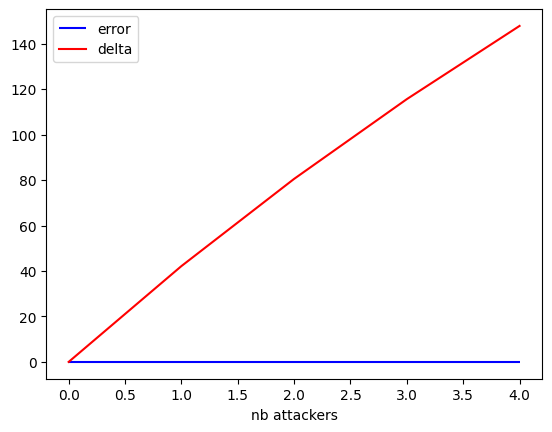

In [20]:
nb_attackers_to_test = np.arange(0, 5, 1)

user_sim = create_sim(ratings_df.iloc[0], ratings_df.drop(0))

sane_pred = pipeline_mean(ratings_df, user_sim, 0, -1)
error = np.abs(real_grade - sane_pred)

delts = np.array([])
for idx, j in enumerate(nb_attackers_to_test):

    delt = compute_delta(ratings_df, nb_attackers=j, algo='mean')
    delts = np.append(delts, delt)

print(delts)
plt.hlines(error, nb_attackers_to_test[0], nb_attackers_to_test[-1], label='error', color='blue')
plt.plot(nb_attackers_to_test, delts, label='delta', color='red')
plt.xlabel('nb attackers')
plt.legend()

plt.show()

In [21]:
print(error)

0.15656150905475397


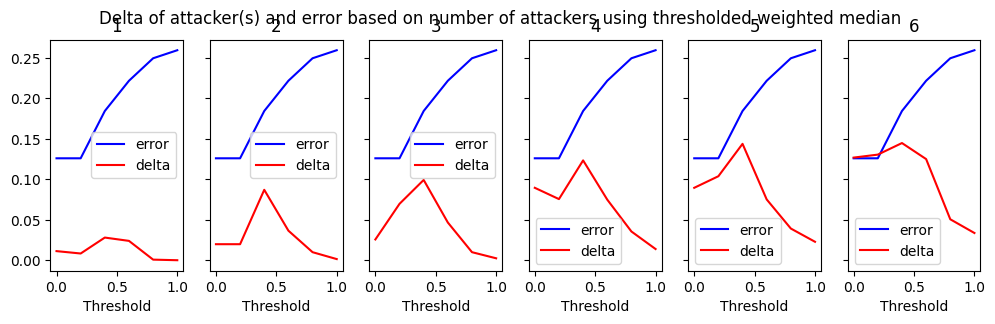

In [25]:
nb_attackers_to_test = np.arange(1, 7, 1)
thresholds = np.arange(0, 1.1, 0.2)

fig, axs = plt.subplots(1, len(nb_attackers_to_test), figsize=(2*len(nb_attackers_to_test), 3), sharex='all', sharey='all')
fig.suptitle('Delta of attacker(s) and error based on number of attackers using thresholded weighted median')

errors = np.array([])

for i in thresholds:
    user_sim = create_sim(ratings_df.iloc[0], ratings_df.drop(0), lower_threshold=i)
    sane_pred = pipeline_median(ratings_df, user_sim, 0, -1, lower_threshold=i)
    errors = np.append(errors, np.abs(real_grade - sane_pred))


for idx, j in enumerate(nb_attackers_to_test):
    delts = np.array([])

    for i in thresholds:
        delt = compute_delta(ratings_df, nb_attackers=j, algo='median', lower_threshold=i)
        delts = np.append(delts, delt)

    axs[idx].set_title(j)
    axs[idx].set_xlabel('Threshold')
    axs[idx].plot(thresholds, errors, label='error', color='blue')
    axs[idx].plot(thresholds, delts, label='delta', color='red')
    axs[idx].legend()

plt.show()

When the threshold increase, the delta increase as well => if the user's group rates an object -1, another group rates 1 and the adversary 1000, the non-thresholded version would still predict -1 since a lot of people are in this group. But if we increase the threshold, the other group gain weight and the prediction can change group because of the adversary.

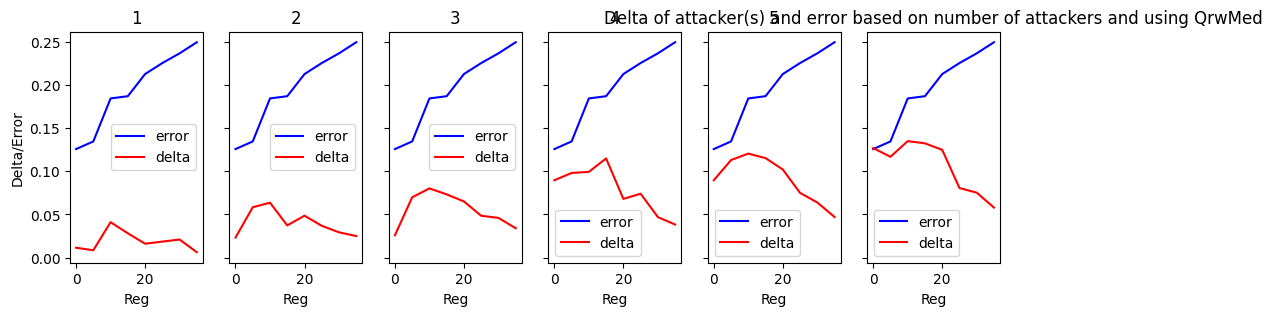

In [26]:
reg_to_test = np.arange(0.0, 40.0, 5.0)
#reg_to_test = np.array([0.1, 0.8, 1.6, 3.2, 6.4, 12.8, 25.6])
nb_attackers_to_test = np.arange(1, 7, 1)

fig, axs = plt.subplots(1, len(nb_attackers_to_test), figsize=(2*len(nb_attackers_to_test), 3), sharex='all', sharey='all')

errors = np.array([])
user_sim = create_sim(ratings_df.iloc[0], ratings_df.drop(0))

for i in reg_to_test:
    sane_pred = pipeline_qrw_med(ratings_df, user_sim, 0, -1, reg=i)
    errors = np.append(errors, np.abs(real_grade - sane_pred))


for idx, j in enumerate(nb_attackers_to_test):
    delts = np.array([])
    for i in reg_to_test:
        delt = compute_delta(ratings_df, reg=i, nb_attackers=j)
        delts = np.append(delts, delt)


    axs[idx].set_title(j)
    axs[idx].set_xlabel('Reg')
    axs[idx].plot(reg_to_test, errors, label='error', color='blue')
    axs[idx].plot(reg_to_test, delts, label='delta', color='red')
    axs[idx].legend()

axs[0].set_ylabel('Delta/Error')
plt.title('Delta of attacker(s) and error based on number of attackers and using QrwMed')
plt.show()


## Edge case: Nobody voted for the item

In [27]:
ratings_df_edge = ratings_df.copy()
ratings_df_edge.iloc[:, -1] = np.nan
ratings_df_edge

,0,1,2,3,4,5,6,7,8,9,...,40,41,42,43,44,45,46,47,48,49
0,-0.394674,NaN,NaN,NaN,-0.227542,0.033453,-0.211666,-0.041365,NaN,-0.410358,...,NaN,NaN,NaN,NaN,NaN,-0.091771,NaN,-0.152258,NaN,NaN
1,-0.281981,NaN,-0.517305,NaN,NaN,NaN,NaN,0.400930,NaN,NaN,...,0.156050,-0.143617,NaN,0.388701,0.135379,-0.325975,NaN,-0.126219,0.015961,NaN
2,NaN,NaN,-0.542684,0.365954,NaN,NaN,NaN,0.305038,NaN,-0.326129,...,NaN,NaN,-0.047419,NaN,NaN,-0.284699,NaN,-0.135756,NaN,NaN
3,NaN,NaN,NaN,-0.005354,NaN,-0.017659,0.005187,NaN,0.014036,NaN,...,NaN,NaN,NaN,NaN,-0.265783,NaN,NaN,0.046497,-0.182657,NaN
4,NaN,NaN,-0.631196,NaN,NaN,0.615980,0.230264,NaN,NaN,-0.301161,...,NaN,-0.347528,-0.075689,NaN,0.084483,-0.225688,-0.067207,-0.125369,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,-0.217740,NaN,NaN,0.300119,-0.773184,0.530891,NaN,0.316591,-0.241072,NaN,...,NaN,-0.284445,-0.010974,NaN,NaN,NaN,NaN,-0.169910,NaN,NaN
96,-0.386010,NaN,0.248895,NaN,-0.131339,-0.031423,NaN,NaN,NaN,NaN,...,-0.148696,NaN,NaN,NaN,NaN,0.004973,-0.062604,NaN,0.322216,NaN
97,-0.127307,0.455464,NaN,0.311222,-0.712594,NaN,0.163919,0.373270,NaN,NaN,...,NaN,NaN,-0.081977,NaN,NaN,NaN,-0.223310,NaN,-0.051357,NaN
98,NaN,-0.006601,0.173605,NaN,0.217927,NaN,NaN,NaN,0.054877,0.145589,...,NaN,NaN,0.036908,NaN,NaN,NaN,NaN,NaN,NaN,NaN


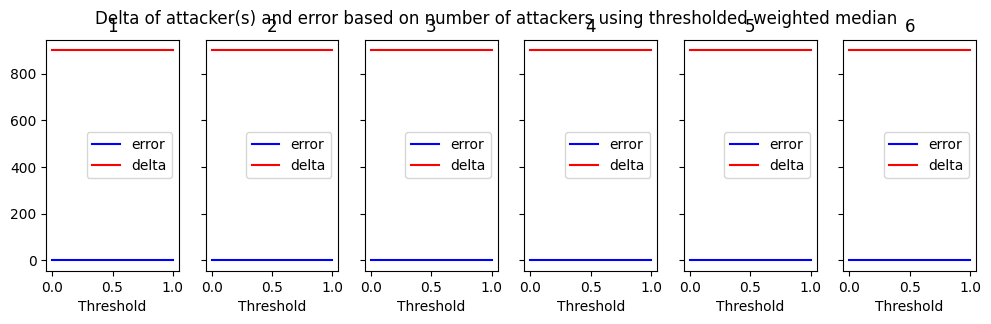

In [28]:
nb_attackers_to_test = np.arange(1, 7, 1)
thresholds = np.arange(0, 1.1, 0.2)

fig, axs = plt.subplots(1, len(nb_attackers_to_test), figsize=(2*len(nb_attackers_to_test), 3), sharex='all', sharey='all')
fig.suptitle('Delta of attacker(s) and error based on number of attackers using thresholded weighted median')

errors = np.array([])
user_sim = create_sim(ratings_df_edge.iloc[0], ratings_df_edge.drop(0))

for i in thresholds:
    sane_pred = pipeline_median(ratings_df_edge, user_sim, 0, -1, lower_threshold=i)
    errors = np.append(errors, np.abs(real_grade - sane_pred))


for idx, j in enumerate(nb_attackers_to_test):
    delts = np.array([])

    for i in thresholds:
        delt = compute_delta(ratings_df_edge, nb_attackers=j, algo='median', lower_threshold=i)
        delts = np.append(delts, delt)

    axs[idx].set_title(j)
    axs[idx].set_xlabel('Threshold')
    axs[idx].plot(thresholds, errors, label='error', color='blue')
    axs[idx].plot(thresholds, delts, label='delta', color='red')
    axs[idx].legend()

plt.show()

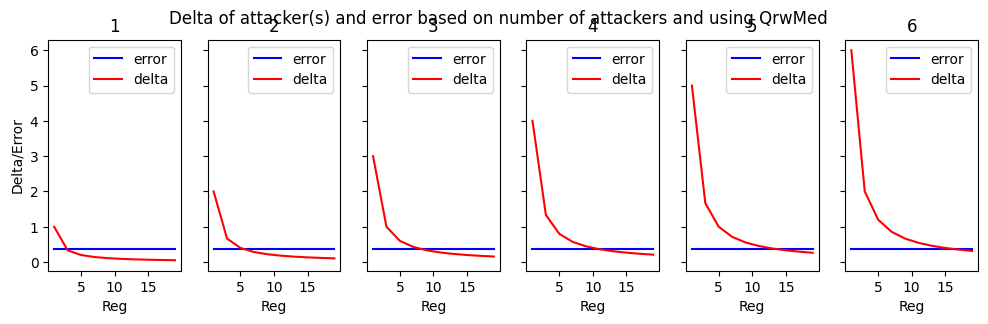

In [28]:
reg_to_test = np.arange(1, 20, 2.0)
#reg_to_test = np.array([0.1, 0.8, 1.6, 3.2, 6.4, 12.8, 25.6])
nb_attackers_to_test = np.arange(1, 7, 1)

fig, axs = plt.subplots(1, len(nb_attackers_to_test), figsize=(2*len(nb_attackers_to_test), 3), sharex='all', sharey='all')
fig.suptitle('Delta of attacker(s) and error based on number of attackers and using QrwMed')


errors = np.array([])
user_sim = create_sim(ratings_df_edge.iloc[0], ratings_df_edge.drop(0))

for i in reg_to_test:

    sane_pred = pipeline_qrw_med(ratings_df_edge, user_sim, 0, -1, reg=i)
    errors = np.append(errors, np.abs(real_grade - sane_pred))


for idx, j in enumerate(nb_attackers_to_test):
    delts = np.array([])
    for i in reg_to_test:
        delt = compute_delta(ratings_df_edge, reg=i, nb_attackers=j)
        delts = np.append(delts, delt)


    axs[idx].set_title(j)
    axs[idx].set_xlabel('Reg')
    axs[idx].plot(reg_to_test, errors, label='error', color='blue')
    axs[idx].plot(reg_to_test, delts, label='delta', color='red')
    axs[idx].legend()

axs[0].set_ylabel('Delta/Error')
plt.show()

Attack: search for 'ideal item' to attack


Metrics: Spearman Footrule, Kendall Tau

Définitions rapport

In [17]:
def run_multiple_epochs(nb_attackers, nb_epochs=5):
    manager = mp.Manager()

    qrwmed_reg_1 = manager.dict()
    qrwmed_reg_5 = manager.dict()
    med_thresh_0 = manager.dict()
    med_thresh_03 = manager.dict()
    mean = manager.dict()

    jobs = []

    for i in range(nb_epochs):

        p = mp.Process(target=run_one_epoch, args=(i, qrwmed_reg_1, qrwmed_reg_5, med_thresh_0, med_thresh_03, mean, nb_attackers))
        jobs.append(p)
        print(f'job {i} started')
        p.start()



    for proc in jobs:
        proc.join()


        '''
        qrwmed_reg_1 = np.append(qrwmed_reg_1, 1/(compute_delta(ratings_att, 0, return_dict, reg=1, nb_attackers=nb_attackers, algo='qrmed')+1))
        qrwmed_reg_5 = np.append(qrwmed_reg_5, 1/(compute_delta(ratings_att, 1, return_dict, reg=5, nb_attackers=nb_attackers, algo='qrmed')+1))
        med_thresh_0 = np.append(med_thresh_0, 1/(compute_delta(ratings_att, 2, return_dict, lower_threshold=0, nb_attackers=nb_attackers, algo='median')+1))
        med_thresh_03 = np.append(med_thresh_03, 1/(compute_delta(ratings_att, 3, return_dict, lower_threshold=0.3, nb_attackers=nb_attackers, algo='median')+1))
        '''
        '''
        qrwmed_reg_1 = np.append(qrwmed_reg_1, 1/(return_dict[0]+1))
        qrwmed_reg_5 = np.append(qrwmed_reg_5, 1/(return_dict[1]+1))
        med_thresh_0 = np.append(med_thresh_0, 1/(return_dict[2]+1))
        med_thresh_03 = np.append(med_thresh_03, 1/(return_dict[3]+1))
        '''

    return np.mean(qrwmed_reg_1.values()), np.mean(qrwmed_reg_5.values()), np.mean(med_thresh_0.values()), np.mean(med_thresh_03.values()), np.mean(mean.values()), np.std(qrwmed_reg_1.values()), np.std(qrwmed_reg_5.values()), np.std(med_thresh_0.values()), np.std(med_thresh_03.values()), np.std(mean.values())

def run_one_epoch(i, qrwmed_reg_1, qrwmed_reg_5, med_thresh_0, med_thresh_03, mean, nb_attackers):

    ratings_df, long_df, meta = generate_synthetic_ratings(
        n_users=100,
        n_items=50,
        n_factors=6,
        n_groups=4,
        group_strength=0.1,
        user_noise=0.1,
        item_scale=0.1,
        user_bias_std=0.0,
        item_bias_std=0.0,
        global_mean=0.0,
        noise_std=0.05,
        rating_min=None,
        rating_max=None,
        random_seed=None
        )

    ratings_df = inject_nans(ratings_df, 0.4, None)

    #real_grade = ratings_df.iloc[0, -1]
    #ratings_att = inject_attackers(ratings_df, nb_attackers=nb_attackers, att_grade=100000)

    qrwmed_reg_1[i] = 1/(compute_delta(ratings_df, reg=1, nb_attackers=nb_attackers, algo='qrmed')+1)
    qrwmed_reg_5[i] = 1/(compute_delta(ratings_df, reg=5, nb_attackers=nb_attackers, algo='qrmed')+1)
    med_thresh_0[i] = 1/(compute_delta(ratings_df, lower_threshold=0, nb_attackers=nb_attackers, algo='median')+1)
    med_thresh_03[i] = 1/(compute_delta(ratings_df, lower_threshold=0.3, nb_attackers=nb_attackers, algo='median')+1)
    mean[i] = 1/(compute_delta(ratings_df, nb_attackers=nb_attackers, algo='mean')+1)

    print(f'job {i} finished')



In [18]:
def plot_multiple_epochs(nb_attackers_to_test, nb_epochs=5):

    qrwmed_reg_1_mean_list = np.array([])
    qrwmed_reg_5_mean_list = np.array([])
    med_thresh_0_mean_list = np.array([])
    med_thresh_03_mean_list = np.array([])
    mean_mean_list = np.array([])

    qrwmed_reg_1_std_list = np.array([])
    qrwmed_reg_5_std_list = np.array([])
    med_thresh_0_std_list = np.array([])
    med_thresh_03_std_list = np.array([])
    mean_std_list = np.array([])

    for nb_attackers in nb_attackers_to_test:

        qrwmed_reg_1_mean, qrwmed_reg_5_mean, med_thresh_0_mean, med_thresh_03_mean, mean_mean, qrwmed_reg_1_std, qrwmed_reg_5_std, med_thresh_0_std, med_thresh_03_std, mean_std  = run_multiple_epochs(nb_attackers, nb_epochs=nb_epochs)

        qrwmed_reg_1_mean_list = np.append(qrwmed_reg_1_mean_list, qrwmed_reg_1_mean)
        qrwmed_reg_5_mean_list = np.append(qrwmed_reg_5_mean_list, qrwmed_reg_5_mean)
        med_thresh_0_mean_list = np.append(med_thresh_0_mean_list, med_thresh_0_mean)
        med_thresh_03_mean_list = np.append(med_thresh_03_mean_list, med_thresh_03_mean)
        mean_mean_list = np.append(mean_mean_list, mean_mean)

        qrwmed_reg_1_std_list = np.append(qrwmed_reg_1_std_list, qrwmed_reg_1_std)
        qrwmed_reg_5_std_list = np.append(qrwmed_reg_5_std_list, qrwmed_reg_5_std)
        med_thresh_0_std_list = np.append(med_thresh_0_std_list, med_thresh_0_std)
        med_thresh_03_std_list = np.append(med_thresh_03_std_list, med_thresh_03_std)
        mean_std_list = np.append(mean_std_list, mean_std)

    # Plot mean line
    plt.plot(nb_attackers_to_test, qrwmed_reg_1_mean_list, color=(0.5, 0.5, 1), label='QrwMed, reg=1')
    plt.plot(nb_attackers_to_test, qrwmed_reg_5_mean_list, color=(0, 0, 1), label='QrwMed, reg=5')
    plt.plot(nb_attackers_to_test, med_thresh_0_mean_list, color=(1, 0.5, 0.5), label='Weighted Median')
    plt.plot(nb_attackers_to_test, med_thresh_03_mean_list, color=(1, 0, 0), label='Weighted Median, lower threshold=0.3')
    plt.plot(nb_attackers_to_test, mean_mean_list, color=(0, 1, 0), label='Weighted Mean')

    # Add shaded error region (mean ± std)
    plt.fill_between(nb_attackers_to_test, qrwmed_reg_1_mean_list - qrwmed_reg_1_std_list, qrwmed_reg_1_mean_list + qrwmed_reg_1_std_list, color=(0.5, 0.5, 1), alpha=0.1)
    plt.fill_between(nb_attackers_to_test, qrwmed_reg_5_mean_list - qrwmed_reg_5_std_list, qrwmed_reg_5_mean_list + qrwmed_reg_5_std_list, color=(0, 0, 1), alpha=0.1)
    plt.fill_between(nb_attackers_to_test, med_thresh_0_mean_list - med_thresh_0_std_list, med_thresh_0_mean_list + med_thresh_0_std_list, color=(1, 0.5, 0.5), alpha=0.1)
    plt.fill_between(nb_attackers_to_test, med_thresh_03_mean_list - med_thresh_03_std_list, med_thresh_03_mean_list + med_thresh_03_std_list, color=(1, 0, 0), alpha=0.1)
    plt.fill_between(nb_attackers_to_test, mean_mean_list - mean_std_list, mean_mean_list + mean_std_list, color=(0, 1, 0), alpha=0.1)

    # Add labels, legend, and grid
    plt.title('possibility of change by the number of attackers per method')
    plt.xlabel('Number of attackers')
    plt.ylabel('Delta')
    #plt.yscale('log')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()

    # Show plot
    plt.show()


job 0 started
job 1 started
job 2 started
job 2 finished
job 0 finished
job 1 finished
job 0 started
job 1 started
job 2 started
job 0 finished
job 1 finished
job 2 finished


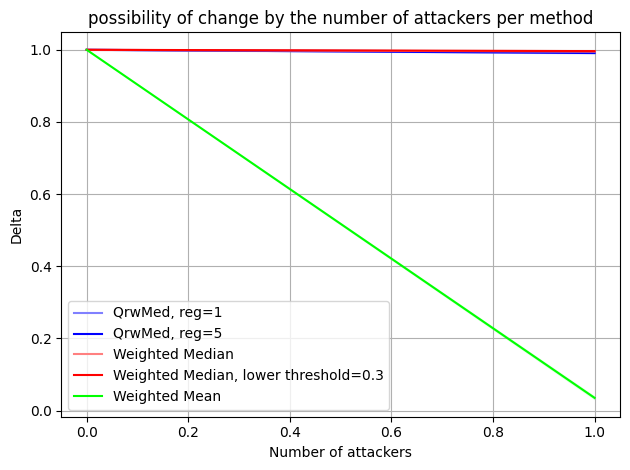

In [19]:
plot_multiple_epochs(np.arange(0, 2, 1), 3)

job 0 started
job 1 started
job 2 started
job 3 started
job 4 started
job 5 started
job 6 started
job 7 started
job 8 started
job 9 started
job 0 finished
job 8 finished
job 5 finished
job 1 finished
job 4 finished
job 9 finished
job 6 finished
job 2 finished
job 7 finished
job 3 finished
[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
job 0 started
job 1 started
job 2 started
job 3 started
job 4 started
job 5 started
job 6 started
job 7 started
job 8 started
job 9 started
job 5 finished
job 6 finished
job 9 finished
job 4 finished
job 7 finished
job 2 finished
job 3 finished
job 1 finished
job 0 finished
job 8 finished
[0.9539187913636485, 0.934492510478418, 0.9898252260836246, 0.9192000193519538, 0.9771880844808599, 0.9782181507147948, 0.9717216650109056, 0.9782513833076434, 0.9919958856963064, 0.9719096939779385]
job 0 started
job 1 started
job 2 started
job 3 started
job 4 started
job 5 started
job 6 started
job 7 started
job 8 started
job 9 started
job 3 finished
job 8 finished

/tmp/ipykernel_39506/3361707143.py:24: RuntimeWarning: invalid value encountered in scalar divide
  new_sim = sumxy/(np.sqrt(sumx)*np.sqrt(sumy))
/tmp/ipykernel_39506/3361707143.py:24: RuntimeWarning: invalid value encountered in scalar divide
  new_sim = sumxy/(np.sqrt(sumx)*np.sqrt(sumy))
/tmp/ipykernel_39506/3361707143.py:24: RuntimeWarning: invalid value encountered in scalar divide
  new_sim = sumxy/(np.sqrt(sumx)*np.sqrt(sumy))
/tmp/ipykernel_39506/3361707143.py:24: RuntimeWarning: invalid value encountered in scalar divide
  new_sim = sumxy/(np.sqrt(sumx)*np.sqrt(sumy))
/tmp/ipykernel_39506/3361707143.py:24: RuntimeWarning: invalid value encountered in scalar divide
  new_sim = sumxy/(np.sqrt(sumx)*np.sqrt(sumy))
/tmp/ipykernel_39506/3361707143.py:24: RuntimeWarning: invalid value encountered in scalar divide
  new_sim = sumxy/(np.sqrt(sumx)*np.sqrt(sumy))
/tmp/ipykernel_39506/3361707143.py:24: RuntimeWarning: invalid value encountered in scalar divide
  new_sim = sumxy/(np.sqrt

job 1 finished
job 5 finished
job 4 finished
job 7 finished
job 9 finished
job 2 finished
job 0 finished
job 3 finished
job 8 finished
job 6 finished
[0.7247912181000642, 0.7129027573142341, 0.9076251537444484, 0.6787710826178903, 0.6698279583171295, 0.8934324588025178, 0.8027562735975884, 0.8830209283497539, 0.9456496809297645, 0.9411816155353974]
job 0 started
job 1 started
job 2 started
job 3 started
job 4 started
job 5 started
job 6 started
job 7 started
job 8 started
job 9 started
job 2 finished
job 8 finished
job 0 finished
job 6 finished
job 7 finished
job 3 finished
job 9 finished
job 1 finished
job 4 finished
job 5 finished
[0.9406734926089542, 0.47069913399278307, 0.9064686726617565, 0.8972065287356182, 0.841333024307676, 0.6407241965008229, 0.85946194668986, 0.5249459426517843, 0.8166757304305464, 0.660695446089201]
job 0 started
job 1 started
job 2 started
job 3 started
job 4 started
job 5 started
job 6 started
job 7 started
job 8 started
job 9 started
job 3 finished
job 4 

/tmp/ipykernel_39506/3361707143.py:24: RuntimeWarning: invalid value encountered in scalar divide
  new_sim = sumxy/(np.sqrt(sumx)*np.sqrt(sumy))
/tmp/ipykernel_39506/3361707143.py:24: RuntimeWarning: invalid value encountered in scalar divide
  new_sim = sumxy/(np.sqrt(sumx)*np.sqrt(sumy))
/tmp/ipykernel_39506/3361707143.py:24: RuntimeWarning: invalid value encountered in scalar divide
  new_sim = sumxy/(np.sqrt(sumx)*np.sqrt(sumy))
/tmp/ipykernel_39506/3361707143.py:24: RuntimeWarning: invalid value encountered in scalar divide
  new_sim = sumxy/(np.sqrt(sumx)*np.sqrt(sumy))
/tmp/ipykernel_39506/3361707143.py:24: RuntimeWarning: invalid value encountered in scalar divide
  new_sim = sumxy/(np.sqrt(sumx)*np.sqrt(sumy))
/tmp/ipykernel_39506/3361707143.py:24: RuntimeWarning: invalid value encountered in scalar divide
  new_sim = sumxy/(np.sqrt(sumx)*np.sqrt(sumy))
/tmp/ipykernel_39506/3361707143.py:24: RuntimeWarning: invalid value encountered in scalar divide
  new_sim = sumxy/(np.sqrt

job 6 finished
job 7 finished
job 3 finished
job 9 finished
job 5 finished
job 1 finished
job 4 finished
job 0 finished
job 2 finished
job 8 finished
[0.12194333128109211, 0.22854426336878772, 0.19117551367971508, 0.11329578631358334, 0.12814125795547862, 0.161364913669082, 0.16419589264029472, 0.10824604616693309, 0.1222394183940659, 0.11518848049873502]
job 0 started
job 1 started
job 2 started
job 3 started
job 4 started
job 5 started
job 6 started
job 7 started
job 8 started
job 9 started
job 8 finished
job 0 finished
job 4 finished
job 7 finished
job 5 finished
job 6 finished
job 2 finished
job 9 finished
job 1 finished
job 3 finished
[0.13904295976362943, 0.09866423848261503, 0.06889816556118887, 0.08836311479383295, 0.10339477872334837, 0.11098836086619393, 0.09412945857863839, 0.1064253239798698, 0.10345361267672618, 0.10236542939688636]
job 0 started
job 1 started
job 2 started
job 3 started
job 4 started
job 5 started
job 6 started
job 7 started
job 8 started
job 9 started
jo

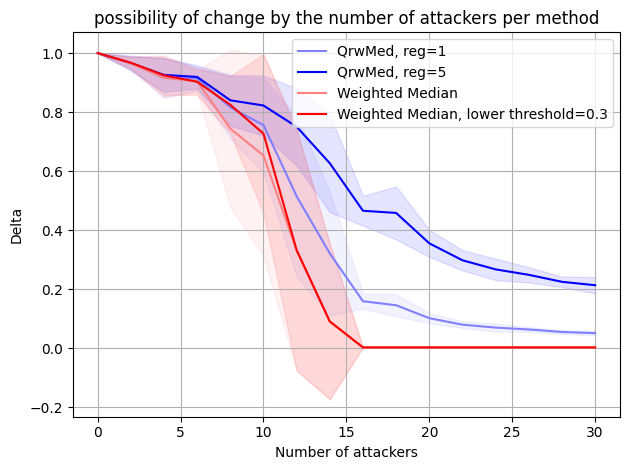

In [37]:
plot_multiple_epochs(np.arange(0, 31, 2), 10)

Take matrix groundtruth

Add Nans

try to fill nans



Use spearman footrule

Mettre au propre

Identifier la meilleure coordonnée pour l'attaque et montrer à quel point ça marche mieux (ou baisser la densité)

## Performances loss

In [ ]:
n_users = 100
n_items = 50

ratings_df, long_df, meta = generate_synthetic_ratings(
        n_users=n_users,
        n_items=n_items,
        n_factors=6,
        n_groups=4,
        group_strength=0.1,
        user_noise=0.1,
        item_scale=0.1,
        user_bias_std=0.0,
        item_bias_std=0.0,
        global_mean=0.0,
        noise_std=0.05,
        rating_min=None,
        rating_max=None,
        random_seed=None
        )



ratings_nans = inject_nans(ratings_df, 0.1, None)

qrwmed_reg0_df = ratings_nans.copy()
qrwmed_reg5_df = ratings_nans.copy()
med_thresh0_df = ratings_nans.copy()
med_thresh03_df = ratings_nans.copy()
mean_df = ratings_nans.copy()

for u in range(n_users):
    user_sim = create_sim(ratings_nans.iloc[u], ratings_nans.drop(u))
    for i in range(n_items):
        if pd.isna(ratings_nans.iloc[u, i]):
            qrwmed_reg0_df.loc[u, i] = pipeline_qrw_med(ratings_nans, user_sim, u, i, reg=0)
            qrwmed_reg5_df.loc[u, i] = pipeline_qrw_med(ratings_nans, user_sim, u, i, reg=5)
            med_thresh0_df.loc[u, i] = pipeline_median(ratings_nans, user_sim, u, i, lower_threshold=0)
            med_thresh03_df.loc[u, i] = pipeline_median(ratings_nans, user_sim, u, i, lower_threshold=0.3)
            mean_df.loc[u, i] = pipeline_mean(ratings_nans, user_sim, u, i)

#filled_df = ratings_nans.map(lambda x: pipeline_qrw_med(ratings_nans, 5) if pd.isna(x) else x)

qrwmed_reg0_error = np.max(np.abs(ratings_df - filled_df))

qrwmed_reg0_error = np.max(np.abs(ratings_df - qrwmed_reg0_df))
qrwmed_reg5_error = np.max(np.abs(ratings_df - qrwmed_reg5_df))
med_thresh0_error = np.max(np.abs(ratings_df - med_thresh0_df))
med_thresh03_error = np.max(np.abs(ratings_df - med_thresh03_df))
mean_error = np.max(np.abs(ratings_df - mean_df))

In [30]:
plt.figure(figsize=(12,5))
plt.bar(['qrwmed_reg0','qrwmed_reg5','med_thresh0','med_thresh03','mean'], [qrwmed_reg5_error,qrwmed_reg0_error,med_thresh0_error,med_thresh03_error,mean_error])

NameError: name 'qrwmed_reg5_error' is not defined

<Figure size 1200x500 with 0 Axes>

## Protection against random users